C:\Users\plc03\anaconda3\envs\ac_grammar_vae\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\plc03\anaconda3\envs\ac_grammar_vae\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\plc03\anaconda3\envs\ac_grammar_vae\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


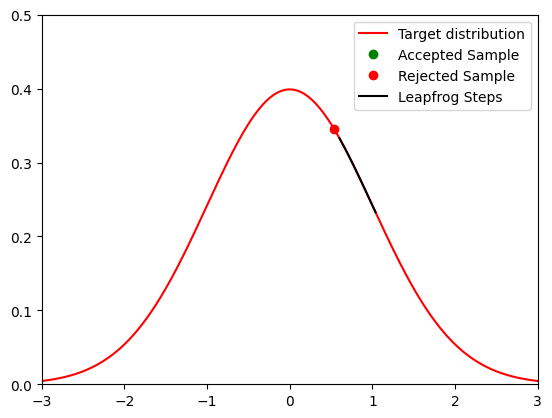

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation #for the videos
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import torch

# target distribution N ~ (0 ,1)
def target_log_prob(x):
    return -0.5 * x**2

# PDF
def target_pdf(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

# HMC Sampling and return every steps
def hmc_sample_with_steps(initial_position, step_size, num_steps, num_samples):
    samples = []
    all_steps = []  # steps for every sampling
    accepted_samples = []  # record if accept it or not

    position = initial_position.clone()

    for _ in range(num_samples):
        steps = []
        # initialization
        momentum = torch.randn_like(position)
        current_hamiltonian = -target_log_prob(position) + 0.5 * momentum**2

        # Leapfrog integration
        position_new = position.clone()
        momentum_new = momentum - 0.5 * step_size * torch.autograd.grad(target_log_prob(position_new), position_new)[0]

        for i in range(num_steps):
            position_new += step_size * momentum_new
            steps.append(position_new.clone().detach().numpy()[0])  
            if i < num_steps - 1:  # momentum at last step will not be updated
                momentum_new -= step_size * torch.autograd.grad(target_log_prob(position_new), position_new)[0]

        momentum_new -= 0.5 * step_size * torch.autograd.grad(target_log_prob(position_new), position_new)[0]
        new_hamiltonian = -target_log_prob(position_new) + 0.5 * momentum_new**2

        # Metropolis-Hastings acceptance step
        if torch.rand(1) < torch.exp(current_hamiltonian - new_hamiltonian):
            position = position_new
            accepted_samples.append(True)
        else:
            accepted_samples.append(False)

        samples.append(position.clone().detach())
        all_steps.append(steps)

    return torch.stack(samples), all_steps, accepted_samples


initial_position = torch.tensor([0.0], requires_grad=True)
samples, all_steps, accepted_samples = hmc_sample_with_steps(initial_position, step_size=0.1, num_steps=6, num_samples=20)

# transfer to numpy
samples_np = samples.numpy().flatten()

# show the process
x = np.linspace(-3, 3, 400)
pdf = target_pdf(x)  

fig, ax = plt.subplots()
ax.plot(x, pdf, 'r-', label='Target distribution')
sampled_point, = ax.plot([], [], 'go', label='Accepted Sample')  
rejected_point, = ax.plot([], [], 'ro', label='Rejected Sample') 
steps_line, = ax.plot([], [], 'k-', label='Leapfrog Steps')  
ax.legend()
ax.set_xlim(-3, 3)
ax.set_ylim(0, 0.5)


total_frames = len(samples_np) * len(all_steps[0])

#visualization
def update(frame):
    #index for every sample and every step for each sample
    sample_idx = frame // len(all_steps[0]) 
    step_idx = frame % len(all_steps[0])

    x_sample = samples_np[sample_idx]
    y_sample = target_pdf(x_sample)

    # update the sample position
    if step_idx == len(all_steps[0]) - 1:  
        if accepted_samples[sample_idx]:
            sampled_point.set_data([x_sample], [y_sample])
            rejected_point.set_data([], [])  # clean the rejected points
        else:
            rejected_point.set_data([x_sample], [y_sample])
            sampled_point.set_data([], [])  # clean the accepted points
    else:
        sampled_point.set_data([], [])
        rejected_point.set_data([], [])

    # update every step
    step_x = all_steps[sample_idx][:step_idx + 1]  
    step_y = target_pdf(np.array(step_x))
    steps_line.set_data(step_x, step_y)  # use the line to connect every points

    return sampled_point, rejected_point, steps_line

ani = FuncAnimation(fig, update, frames=total_frames, blit=True, repeat=True, interval=500)  # time interval can be set

# save as HTML
html_content = ani.to_jshtml()
with open(r"D:\24SS\MA\files\animation.html", "w") as f:
    f.write(html_content)

#save
HTML(html_content)

plt.show()

In [2]:
from IPython.display import HTML

# 在 Jupyter Notebook 中直接显示动画
HTML(ani.to_jshtml())